In [1]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Function to load MFCC features and labels from numpy arrays
def load_data(directory):
    mfcc_features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            if not os.path.isfile(file_path):
                continue
            mfcc = np.load(file_path)
            mfcc_features.append(mfcc)
            labels.append(label)
    return np.array(mfcc_features), np.array(labels)

In [3]:
TRAINING_DIR = '/content/drive/MyDrive/BeeMFCC/BeeMFCC/TrainMFCC'
VALIDATION_DIR = '/content/drive/MyDrive/BeeMFCC/BeeMFCC/ValMFCC'
TEST_DIR = '/content/drive/MyDrive/BeeMFCC/BeeMFCC/TestMFCC'

In [4]:
import os

# Function to count the number of files in a directory and its subdirectories
def count_files(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    return file_count


# Count files in the training directory
training_file_count = count_files(TRAINING_DIR)

# Count files in the validation directory
validation_file_count = count_files(VALIDATION_DIR)

# Count files in the test directory
test_file_count = count_files(TEST_DIR)

print("Training files:", training_file_count)
print("Validation files:", validation_file_count)
print("Test files:", test_file_count)


Training files: 14000
Validation files: 2000
Test files: 4000


In [5]:
# Load the data
train_hht_features, train_labels = load_data(TRAINING_DIR)
val_hht_features, val_labels = load_data(VALIDATION_DIR)
test_hht_features, test_labels = load_data(TEST_DIR)

In [6]:
# Convert labels to numeric values
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

# Convert the data to NumPy arrays
X_train = np.array(train_hht_features)
y_train = np.array(encoded_train_labels)

X_val = np.array(val_hht_features)
y_val = np.array(encoded_val_labels)

X_test = np.array(test_hht_features)
y_test = np.array(encoded_test_labels)

# Reshape the input data
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [7]:
# Determine the shape of the HHT features
input_shape = X_train.shape[1:]

# Define the model architecture
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(16, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = create_model(input_shape=input_shape)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the callback for stopping training
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99:
            print("\nReached 99% accuracy. Stopping training.")
            self.model.stop_training = True

# Train the model with the callback
stop_training_callback = StopTrainingCallback()
history = model.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val), callbacks=[stop_training_callback])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/120
438/438 [==============================] - 5s 6ms/step - loss: 0.5947 - accuracy: 0.6985 - val_loss: 0.4424 - val_accuracy: 0.7855
Epoch 2/120
438/438 [==============================] - 3s 6ms/step - loss: 0.3979 - accuracy: 0.8136 - val_loss: 0.3283 - val_accuracy: 0.8450
Epoch 3/120
438/438 [==============================] - 3s 8ms/step - loss: 0.3554 - accuracy: 0.8371 - val_loss: 0.3209 - val_accuracy: 0.8505
Epoch 4/120
438/438 [==============================] - 4s 8ms/step - loss: 0.3222 - accuracy: 0.8524 - val_loss: 0.2833 - val_accuracy: 0.8770
Epoch 5/120
438/438 [==============================] - 3s 6ms/step - loss: 0.3047 - accuracy: 0.8621 - val_loss: 0.3473 - val_accuracy: 0.8290
Epoch 6/120
438/438 [==============================] - 3s 6ms/step - loss: 0.2831 - accuracy: 0.8744 - val_loss: 0.2538 - val_accuracy: 0.9045
Epoch 7/120
438/438 [==============================] - 3s 6ms/step - loss: 0.2723 - accuracy: 0.8766 - val_loss: 0.2904 - val_accuracy: 0.8635

In [ ]:
model.save('/content/drive/MyDrive/Models/HTTsigmoid1D.h5')

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)


125/125 [==============================] - 1s 4ms/step
Precision: 0.9584615384615385
Recall: 0.9345
F1-score: 0.9463291139240506
Accuracy: 0.947
Confusion Matrix:
[[1919   81]
 [ 131 1869]]


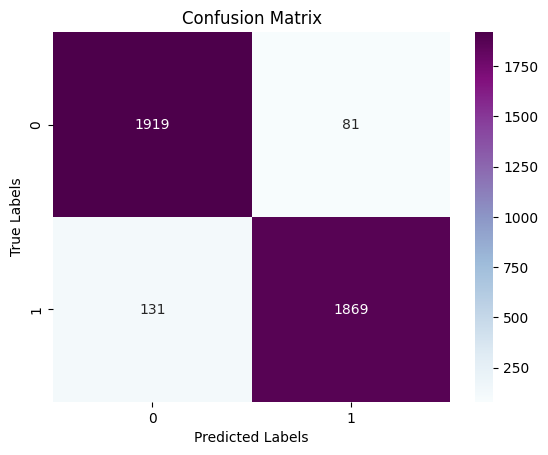

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Plot confusion matrix
sns.heatmap(confusion, annot=True, fmt="d", cmap="BuPu")  # Change the colormap here
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

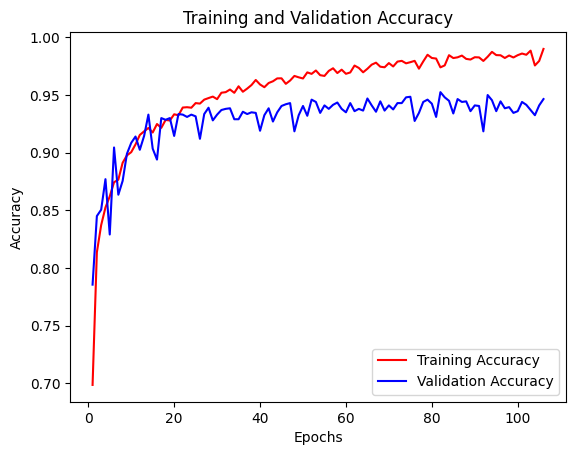

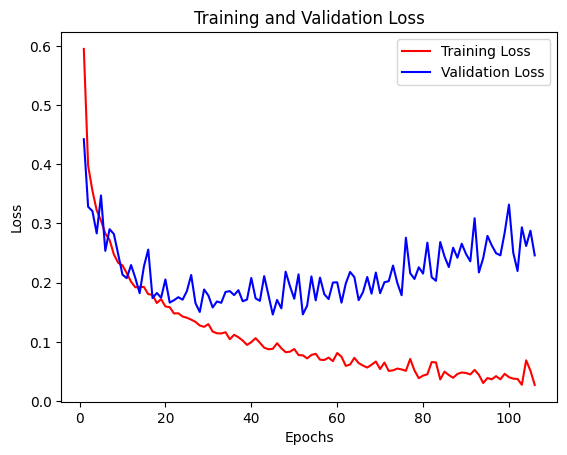

In [10]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate the epochs values
epochs = range(1, len(acc) + 1)

# Create the plot for accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Create the plot for loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()